In [8]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from model import build_model, FRAME_W, FRAME_H
from keras.preprocessing.image import img_to_array
from vis.utils import utils

In [2]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from model import build_model, FRAME_W, FRAME_H
from keras import backend as K
import tensorflow as tf
from keras.preprocessing.image import img_to_array

from skater.util.image_ops import load_image, show_image, normalize, add_noise, flip_pixels, image_transformation

(70, 180, 3)


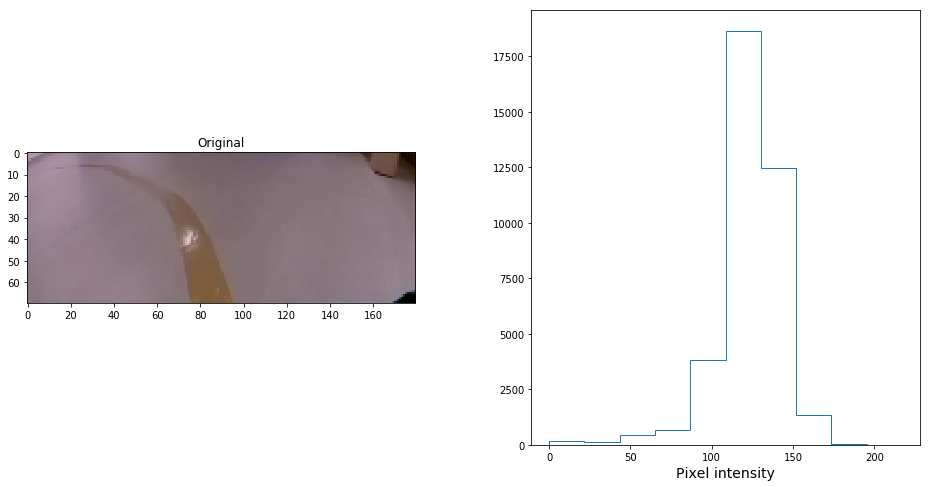

In [17]:
model = build_model()
model.load_weights('weights.hdf5')
img = utils.load_img('images/left.png', target_size=(FRAME_H, FRAME_W))
#img = load_image('images/left.png', FRAME_W, FRAME_H)
print(img.shape)
show_image(img)

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 70, 180, 3)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 66, 176, 8)        608       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 33, 88, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 29, 84, 16)        3216      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 42, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 38, 32)        12832     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 5, 19, 32)         0         
__________

Predicted [[-0.93429124]]


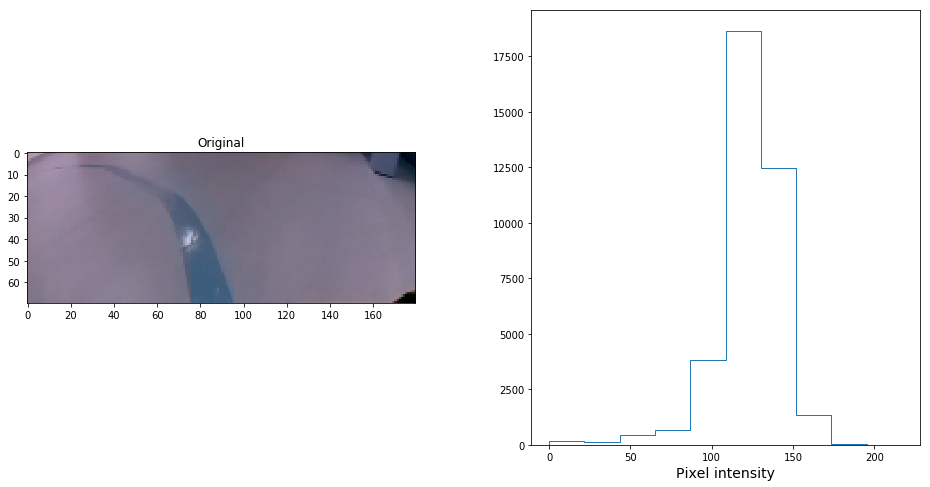

In [20]:
from vis.utils import utils
bgr_img = utils.bgr2rgb(img)
img_input = bgr_img.reshape((1,) + bgr_img.shape)
show_image(img_input[0])
pred = model.predict(img_input)
print('Predicted {}'.format(pred))

In [21]:
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter
from skater.core.visualizer.image_relevance_visualizer import visualize

sess = tf.Session()
K.set_session(sess)

K.set_learning_phase(0)
with DeepInterpreter(session=K.get_session()) as di:
    loaded_model = build_model()
    loaded_model.load_weights('weights.hdf5')
    print("Loaded model from disk")
    input_tensor = loaded_model.layers[0].input
    print(input_tensor)
    output_tensor = loaded_model.layers[-1].output
    print(output_tensor)
    input_x = img_input
    print(input_x.shape)
    print(loaded_model.predict(img_input))
    optional_args = {"window_size": 1, "step": 1}
    relevance_scores = {
        'integrated gradient': di.explain('ig', output_tensor, input_tensor, input_x, use_case='image'),
        'e-LRP': di.explain('elrp', output_tensor, input_tensor, input_x, use_case='image'),
        'occlusion': di.explain('occlusion', output_tensor, input_tensor, input_x, use_case='image', **optional_args)
    }

2018-06-01 02:57:38,292 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrated Gradient


Loaded model from disk
Tensor("input_7:0", shape=(?, 70, 180, 3), dtype=float32)
Tensor("dense_14/Tanh:0", shape=(?, 1), dtype=float32)
(1, 70, 180, 3)
[[-0.93429124]]


2018-06-01 02:57:39,243 - LRP - INFO - Epsilon value: 0.0001
2018-06-01 02:57:39,244 - BaseGradientMethod - INFO - Executing operations ...
2018-06-01 02:57:39,338 - Occlusion - INFO - Input shape: (70, 180, 3); window_size/step: (1/1); replace value: 0; batch size: 1
2018-06-01 02:57:39,339 - Occlusion - INFO - Shape of the mask patch: (4,)
2018-06-01 02:57:39,358 - Occlusion - INFO - shape of the default eval value :(1, 1)
2018-06-01 02:58:21,492 - Occlusion - INFO - Min/Max normalizer weight: 1/180
2018-06-01 02:58:21,493 - Occlusion - INFO - relevance score matrix shape :(1, 70, 180, 3)


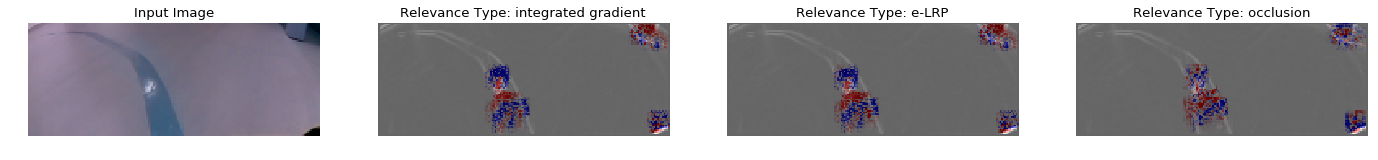

In [22]:
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 11

n_cols = int(len(relevance_scores)) + 1
n_rows = len(img_input) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(img_input):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Input Image')
    ax.axis('off')
    for j, r_type in enumerate(relevance_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevance_scores[r_type][i], original_input_img=xi, axis=axj, 
                  percentile=99, alpha_edges=1, alpha_bgcolor=0.4).set_title("Relevance Type: {}".format(r_type))